<a href="https://colab.research.google.com/github/widyamelia26/Javanese-Letter-Recognition/blob/main/CODE%20FIX/aksara_jawa_InceptionResNetv2%20(50%20epoch)%20(1e-4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash

# Check if the dataset already exists
if test -e "aksara-jawa-dataset.zip"; then
    rm -rf aksara-jawa-dataset.zip ./data ./data-test
    kaggle datasets download -d rfahrur6045/aksara-jawa-dataset
    unzip aksara-jawa-dataset.zip
else
    kaggle datasets download -d rfahrur6045/aksara-jawa-dataset
    unzip aksara-jawa-dataset.zip
fi

# Remove unnecessary files
rm -f ./data/LICENSE ./data/LICENSE.md ./data/README.md
rm -f ./data-test/LICENSE ./data-test/LICENSE.md ./data-test/README.md

Dataset URL: https://www.kaggle.com/datasets/rfahrur6045/aksara-jawa-dataset
License(s): unknown

Archive:  aksara-jawa-dataset.zip
  inflating: data-test/ba/test-ba1.png  
  inflating: data-test/ba/test-ba2.png  
  inflating: data-test/ca/test-ca1.png  
  inflating: data-test/ca/test-ca2.png  
  inflating: data-test/ca/test-ca3.png  
  inflating: data-test/ca/test-ca4.png  
  inflating: data-test/da/test-da1.png  
  inflating: data-test/da/test-da2.png  
  inflating: data-test/dha/test-dha1.png  
  inflating: data-test/dha/test-dha2.png  
  inflating: data-test/dha/test-dha3.png  
  inflating: data-test/ga/test-ga1.png  
  inflating: data-test/ga/test-ga2.png  
  inflating: data-test/ga/test-ga3.png  
  inflating: data-test/ha/ha_test1.png  
  inflating: data-test/ha/ha_test2.png  
  inflating: data-test/ha/ha_test3.png  
  inflating: data-test/ha/ha_test4.png  
  inflating: data-test/ha/ha_test5.png  
  inflating: data-test/ja/test-ja1.png  
  inflating: data-test/ja/test-ja2.png  
 

100%|██████████| 193M/193M [00:12<00:00, 16.9MB/s]


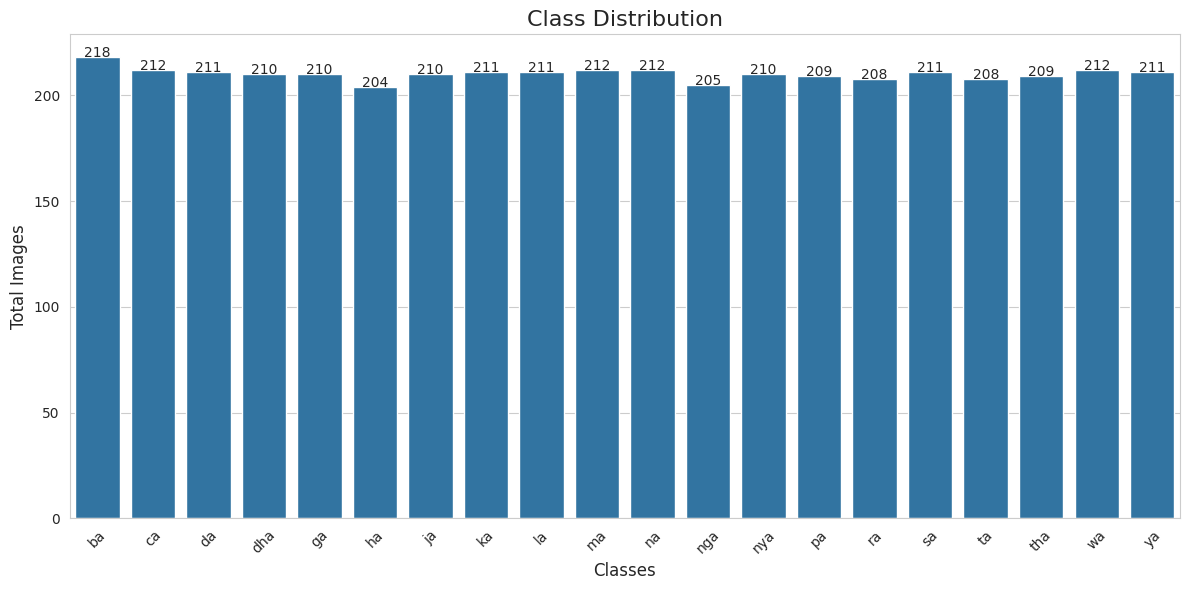

In [2]:
import glob

import matplotlib.pyplot as plt
import seaborn as sns


train_path = "./data"
test_path = "./data-test"
class_names = ["ba","ca","da","dha","ga","ha","ja",
               "ka","la","ma","na","nga","nya","pa",
               "ra","sa","ta","tha","wa","ya"]
class_distribution = {}

# Put image paths to dictionary using class names as keys.
for class_name in class_names:
    class_distribution[class_name] = len(glob.glob(f"{train_path}/{class_name}/*"))

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))

plt.title("Class Distribution", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Total Images", fontsize=12)
plt.xticks(rotation=45)

# Add value labels of each bar.
for index, value in enumerate(class_distribution.values()):
    plt.text(index, value, str(value), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

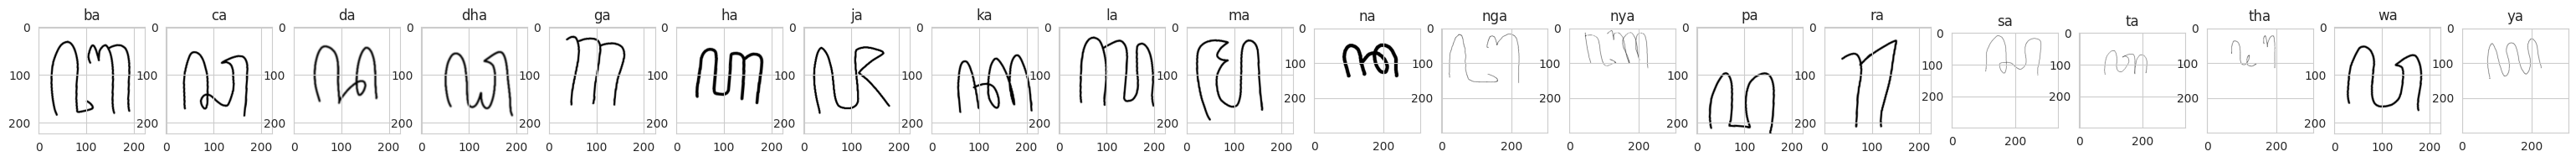

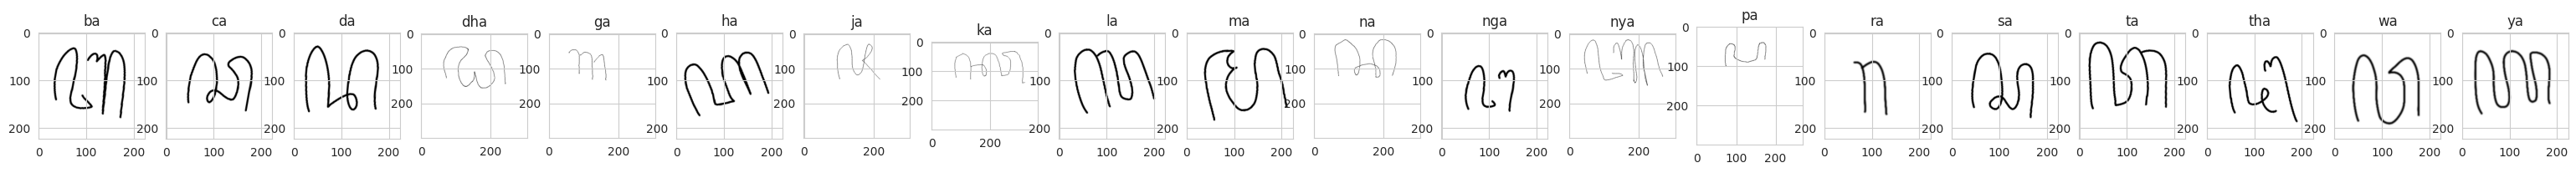

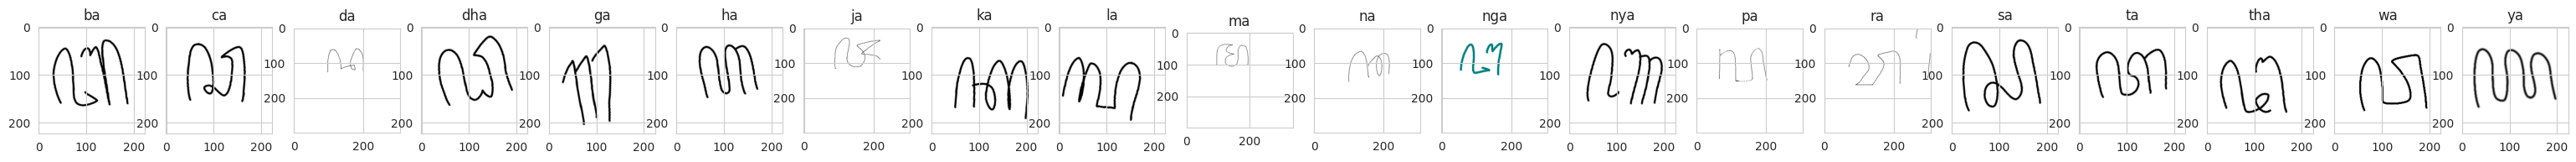

In [3]:
import cv2
import numpy as np


def plot_sample_images(class_names):
    fig, axis = plt.subplots(1, len(class_names), figsize=[39,45])

    for index, (class_name, count) in enumerate(class_distribution.items()):
        # Randomly choose images to plot.
        random_index = np.random.randint(0, count)
        img_read = cv2.imread(
            glob.glob(f"{train_path}/{class_name}/*")[random_index]
        )

        axis[index].imshow(img_read)
        axis[index].set_title(class_name)

# Plot several samples of each class.
for i in range(0, 3):
    plot_sample_images(class_names)

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input



# Data generator for traning and validation.
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2, # 20% of images to be used for validation.
    preprocessing_function=preprocess_input
    )

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    subset="training",
    shuffle=True
    )

validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # 20% of images to be used for validation.
    preprocessing_function=preprocess_input
    )

validation_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    subset="validation",
    shuffle=False
)

Found 3369 images belonging to 20 classes.
Found 834 images belonging to 20 classes.


In [12]:
# Data generator for evaluation.
test_data_generator = ImageDataGenerator(rescale=1./255,
                                         preprocessing_function=preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle = False  # Keep this False for confusion matrix.
)

Found 55 images belonging to 20 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Create enhanced model with Inception v2
def create_model(num_classes):
    base_model = InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )

    # Freeze only the first few layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    # Add custom layers with stronger regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First dense block
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.4)(x)

    # Second dense block
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

def visualize_model_architecture(model):
    """
    Visualize the model architecture using plot_model
    """
    # Create the model flowchart
    plot_model(
        model,
        to_file='cnn_model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='LR'
    )

    # Display the flowchart
    plt.figure(figsize=(15, 10))
    img = plt.imread('cnn_model.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Model Architecture')
    plt.show()

In [7]:
def create_callbacks():
    """
    Create enhanced callbacks for better training
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,              # Increased patience
        restore_best_weights=True,
        min_delta=0.001          # Minimum change to qualify as an improvement
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,              # More aggressive LR reduction
        patience=8,              # Reduced patience for LR reduction
        min_lr=1e-7,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    return early_stopping, reduce_lr, checkpoint

def train_model(model, train_generator, validation_generator):
    early_stopping, reduce_lr, checkpoint = create_callbacks()

    # Use a learning rate schedule
    initial_learning_rate = 1e-4
    # decay_steps = 1000
    # decay_rate = 0.9

    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate,
    #     decay_steps=decay_steps,
    #     decay_rate=decay_rate
    # )

    f1 = tf.keras.metrics.F1Score(average='macro', threshold=0.5)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', f1]
    )

    # Train with class weights if dataset is imbalanced
    history = model.fit(
        train_generator,
        epochs=50,  # Increased epochs since we have better regularization
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint],
    )

    return history

In [8]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

In [9]:
def main(train_generator, validation_generator):
    # Create data generators
    train_generator, validation_generator = train_generator, validation_generator

    # Create model
    num_classes = len(train_generator.class_indices)
    model, base_model = create_model(num_classes)

    # Initial training with frozen base layers
    history = train_model(model, train_generator, validation_generator)
    plot_training_history(history)

    return model, base_model


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0706 - f1_score: 0.0057 - loss: 4.5380
Epoch 1: val_accuracy improved from -inf to 0.04796, saving model to best_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.0708 - f1_score: 0.0057 - loss: 4.5371 - val_accuracy: 0.0480 - val_f1_score: 0.0000e+00 - val_loss: 4.2190 - learning_rate: 1.0000e-04
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2589 - f1_score: 0.1251 - loss: 3.5907
Epoch 2: val_accuracy improved from 0.04796 to 0.05635, saving model to best_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.2599 - f1_score: 0.1262 - loss: 3.5871 - val_accuracy: 0.0564 - val_f1_score: 0.0000e+00 - val_loss: 4.5686 - learning_rate: 1.0000e-04
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6210 - f1_score: 0.5444 - loss: 2.3633
Epoch 3: val_accuracy improved from 0.05635 to 0.39089, saving model to best_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accurac

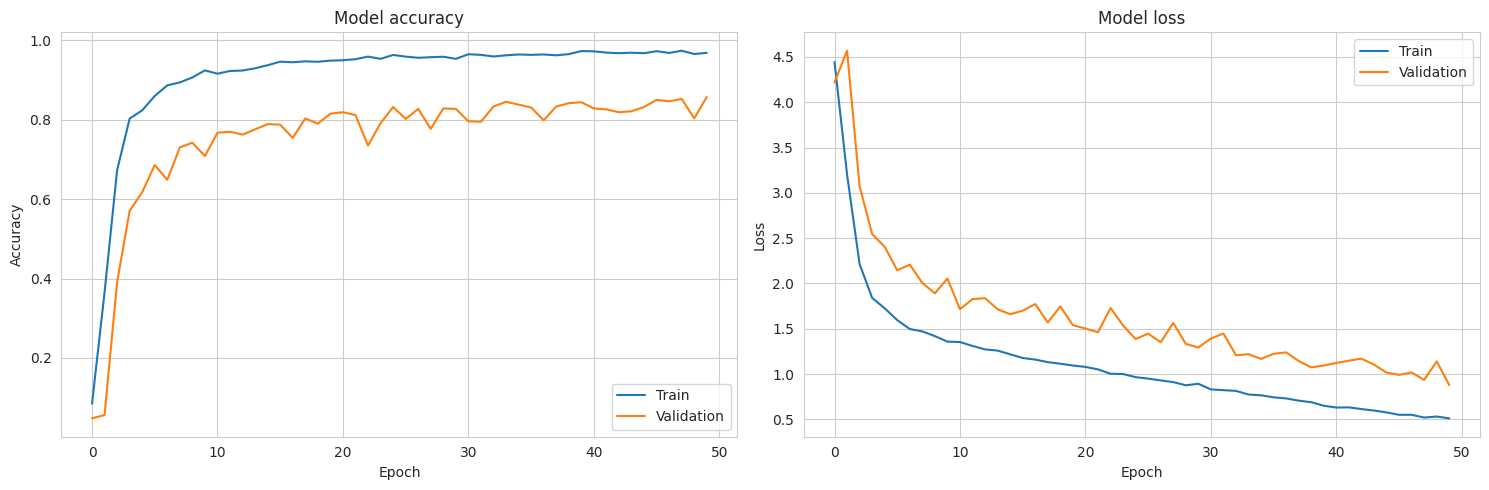

In [10]:
if __name__ == "__main__":
    model, base_model = main(train_generator, validation_generator)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Accuracy Testing: 0.8545
F1-Score Testing: 0.8417


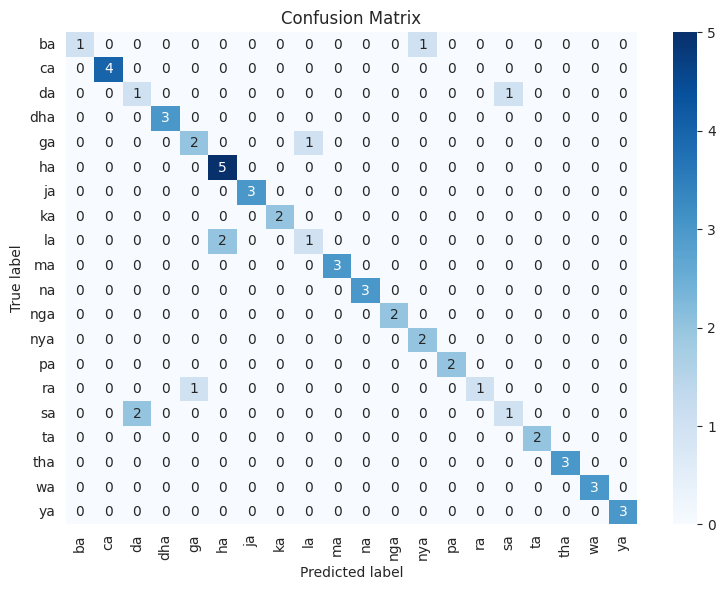

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Nama-nama kelas emosi
class_names = ["ba","ca","da","dha","ga","ha","ja",
               "ka","la","ma","na","nga","nya","pa",
               "ra","sa","ta","tha","wa","ya"]

# Peroleh true labels dari test generator
true_labels = test_generator.classes

# Reset test generator sebelum prediksi
test_generator.reset()

# Dapatkan prediksi model pada data test
predicted = model.predict(test_generator)
predicted_labels = np.argmax(predicted, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Menghitung Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy Testing: {accuracy:.4f}")

# Menghitung F1-Score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1-Score Testing: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()